#### Natalia Allmi


### Problem 2

In [1]:
#import libraries
import matplotlib.pyplot as plt
import numpy as np

#### 1 a) Show your estimated seasonal component

In [2]:
t = [1,2,3,4,5,6,7,8,9]
xt = [11.81,8.46,10.35,12.33,8.54,7.44,9.02,8.52,6.92]
d=3 #periodicity

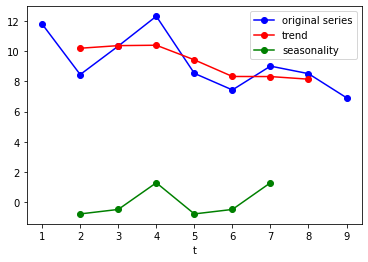

In [3]:
#LOCAL FILTERING

trend = np.convolve(xt, [1/3,1/3,1/3], mode="valid")
seasonality = xt[1:-1] - trend

seasonality_avg = []
seasonality_new = []

for i in range(3):
    seasonality_avg.append(np.mean(seasonality[i::3]))
    
for i in range(3):
    seasonality_new.append(seasonality_avg[i] - np.mean(seasonality_avg))
    
plt.plot(t, xt, 'bo-', label = 'original series')
plt.plot(t[1:-1], trend, 'ro-', label = "trend")
plt.plot(t[1:-2], seasonality_new*2, 'go-', label="seasonality")
plt.legend()
plt.xlabel('t')
plt.show()

##### b) Write down your time series after removing the seasonality

In [4]:
st=[]
st.append(seasonality_new[2])
st.extend(seasonality_new*2)
st.extend(seasonality_new[0:2])

In [5]:
np.array(xt)-np.array(st)

array([10.53092593,  9.24814815, 10.84092593, 11.05092593,  9.32814815,
        7.93092593,  7.74092593,  9.30814815,  7.41092593])

### Problem 3

In [6]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from geopy import distance
from sklearn.cluster import AgglomerativeClustering
from math import radians, cos, sin, asin, sqrt
from sklearn.metrics.pairwise import haversine_distances
from sklearn.neighbors import DistanceMetric
from sklearn.metrics import silhouette_score
import seaborn as sns
import networkx as nx
from shapely.geometry import MultiPoint
from geopy.distance import great_circle

import warnings
warnings.filterwarnings("ignore")

In [7]:
#read data
df = pd.read_csv("bike_share.csv")

##### (1) Visualize the data and describe the summary statistics

In [8]:
df.head()

,rideable_type,started_at,ended_at,start_lat,start_lng,end_lat,end_lng,member_casual
0,electric_bike,2022-05-10 16:37:36,2022-05-10 16:53:30,40.675833,-74.014726,40.657743,-74.001141,member
1,electric_bike,2022-05-28 19:15:31,2022-05-28 19:17:13,40.756458,-73.993722,40.754623,-73.995168,member
2,electric_bike,2022-05-21 11:34:43,2022-05-21 11:36:52,40.756458,-73.993722,40.754623,-73.995168,member
3,classic_bike,2022-05-21 14:03:40,2022-05-21 17:01:43,40.756951,-73.982631,40.754623,-73.995168,casual
4,electric_bike,2022-05-23 14:33:17,2022-05-23 14:43:40,40.756951,-73.982631,40.754623,-73.995168,casual


In [9]:
#check for missing values
df.isna().sum()

rideable_type    0
started_at       0
ended_at         0
start_lat        0
start_lng        0
end_lat          0
end_lng          0
member_casual    0
dtype: int64

In [10]:
df.describe()

,start_lat,start_lng,end_lat,end_lng
count,20000.000000,20000.000000,20000.000000,20000.000000
mean,40.740842,-73.976050,40.740701,-73.975684
std,0.038608,0.025299,0.039001,0.024994
min,40.633385,-74.027472,40.633385,-74.042817
25%,40.716250,-73.993934,40.716021,-73.994156
50%,40.739535,-73.981693,40.739355,-73.981225
75%,40.762699,-73.959586,40.761330,-73.958660
max,40.882260,-73.881450,40.879350,-73.881450


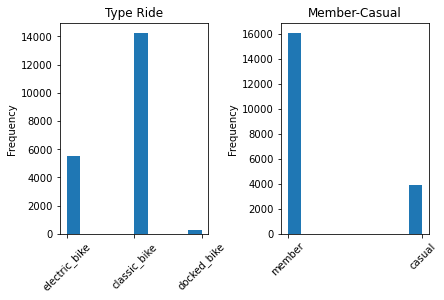

In [11]:

plt.subplot(1, 2, 1)
plt.hist(df.rideable_type)
plt.title('Type Ride')
plt.ylabel('Frequency')
plt.xticks(rotation= 45)

plt.subplot(1, 2, 2)
plt.hist(df.member_casual)
plt.title('Member-Casual')
plt.ylabel('Frequency')
plt.xticks(rotation= 45)
plt.tight_layout(pad=0.1)
plt.show()

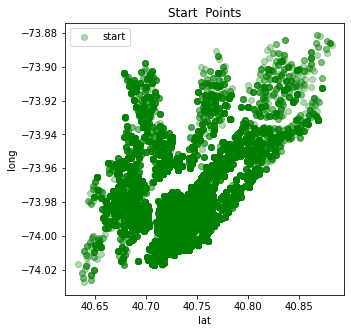

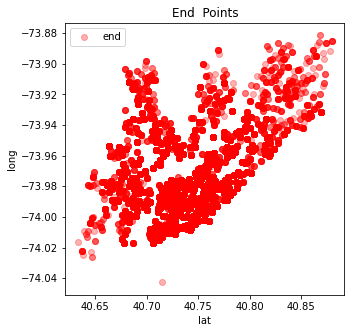

In [12]:
plt.figure(figsize=(5,5))
plt.scatter(df.start_lat, df.start_lng, color='g', alpha=0.3, label='start')
plt.legend()
plt.title('Start  Points')
plt.xlabel('lat')
plt.ylabel('long')
plt.show()

plt.figure(figsize=(5,5))
plt.scatter(df.end_lat, df.end_lng, color='r', alpha=0.3, label='end')
plt.legend()
plt.title('End  Points')
plt.xlabel('lat')
plt.ylabel('long')
plt.show()

In [13]:
#there are trips with 0 distance. These have same starting lat, long and end lat,long.
# I consider these trips as wrongly reported, so i eliminate them from the data set.
df = df.loc[df.start_lat != df.end_lat,]

In [14]:
df.reset_index(inplace=True, drop=True)

In [15]:
#remove outlier point seem in end points under -74.04 long
df = df.loc[df.end_lng > -74.04,]
df.reset_index(inplace=True, drop=True)

##### (2) Compute trip-time, trip distance, and trip-speed statistics from the given data. Plot their distributions. Discuss these quantities with respect to the other features in the data.

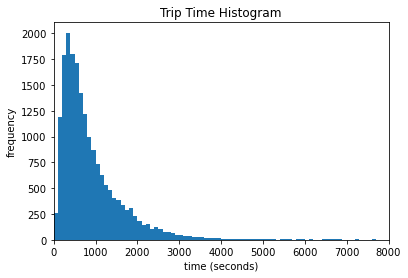

In [16]:
#trip time
df['time'] = pd.to_datetime(df.ended_at)-pd.to_datetime(df.started_at)

time = []
for i in range(0,len(df.time)):
    
    t = df['time'][i].total_seconds()
    time.append(t)
    
df['time_seconds']=time


#filter out trip with time =0
df = df.loc[df.time_seconds != 0,]
df.reset_index(inplace=True,drop=True)


plt.hist(df.time_seconds, bins=range(0,10000,100))
plt.xlim(0,8000)
plt.title('Trip Time Histogram')
plt.xlabel('time (seconds)')
plt.ylabel('frequency')
plt.show()

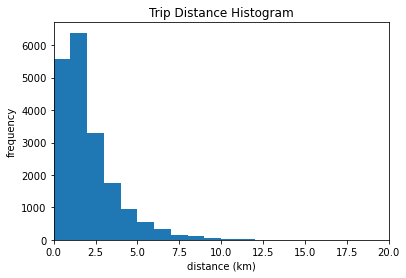

In [17]:
#trip distance

dist=[]

for i in range(0,df.shape[0]):
    start=(df.start_lat[i], df.start_lng[i])
    end=(df.end_lat[i],df.end_lng[i])
    d =distance.distance(start, end).km
    dist.append(d)
    
df['distance_km']=dist 

plt.hist(df.distance_km, bins=range(0,20,1))
plt.xlim(0,20)
plt.title('Trip Distance Histogram')
plt.xlabel('distance (km)')
plt.ylabel('frequency')
plt.show()


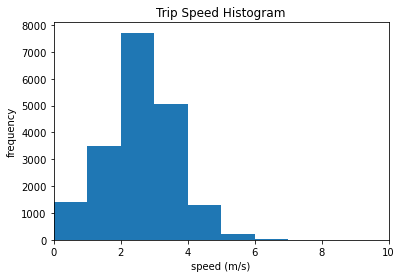

In [18]:
#trip speed

#distance is in km. Turn to meters
df['distance_m']=df.distance_km*1000

df['speed_m/s']=df['distance_m']/df['time_seconds']

plt.hist(df['speed_m/s'], bins=range(0,10,1))
plt.xlim(0,10)
plt.title('Trip Speed Histogram')
plt.xlabel('speed (m/s)')
plt.ylabel('frequency')
plt.show()


In [19]:
df[['time_seconds', 'distance_km', 'speed_m/s']].describe()

,time_seconds,distance_km,speed_m/s
count,19200.000000,19200.000000,19200.000000
mean,993.660833,2.048921,2.604466
std,4420.139754,1.696485,1.032849
min,2.000000,0.003177,0.001882
25%,376.750000,0.904709,1.985943
50%,658.000000,1.545347,2.621879
75%,1159.250000,2.679358,3.252760
max,561824.000000,21.219067,6.953094


In [20]:
#pre-processing

#eliminate outliers according to time 
Q1 = np.percentile(df['time_seconds'] , 25, interpolation = 'midpoint')
Q3 = np.percentile(df['time_seconds'] , 75, interpolation = 'midpoint')
IQR = Q3 - Q1
upper_bound = df['time_seconds'] >= (Q3+1.5*IQR)
lower_bound = df['time_seconds'] <= (Q1-1.5*IQR)

upper_points = np.where(upper_bound)
df.drop(upper_points[0], inplace=True)

lower_points = np.where(lower_bound)
df.drop(lower_points[0], inplace=True)

#eliminate outliers according to distance
df.reset_index(inplace=True, drop=True)

Q1 = np.percentile(df['distance_km'] , 25, interpolation = 'midpoint')
Q3 = np.percentile(df['distance_km'] , 75, interpolation = 'midpoint')
IQR = Q3 - Q1
upper_bound = df['distance_km'] >= (Q3+1.5*IQR)
lower_bound = df['distance_km'] <= (Q1-1.5*IQR)

upper_points = np.where(upper_bound)
df.drop(upper_points[0], inplace=True)

lower_points = np.where(lower_bound)
df.drop(lower_points[0], inplace=True)

#eliminate outliers according to speed
df.reset_index(inplace=True, drop=True)

Q1 = np.percentile(df['speed_m/s'] , 25, interpolation = 'midpoint')
Q3 = np.percentile(df['speed_m/s'] , 75, interpolation = 'midpoint')
IQR = Q3 - Q1
upper_bound = df['speed_m/s'] >= (Q3+1.5*IQR)
lower_bound = df['speed_m/s'] <= (Q1-1.5*IQR)

upper_points = np.where(upper_bound)
df.drop(upper_points[0], inplace=True)

lower_points = np.where(lower_bound)
df.drop(lower_points[0], inplace=True)

In [21]:
df.reset_index(inplace=True,drop=True)

##### (3) Step-wise describe your approach to identify similar trips based on the criteria mentioned above and which clustering algorithm is suitable here.

In [22]:
#see report

##### (4) Apply your approach, group the trips, and visualize the clusters using different plots.

In [23]:
#https://stackoverflow.com/questions/34557898/pairwise-haversine-distance-calculation
#calculate distance between points
def sklearn_haversine(lat, lon):
    haversine = DistanceMetric.get_metric('haversine')
    latlon = np.hstack((lat[:, np.newaxis], lon[:, np.newaxis]))
    dists = haversine.pairwise(latlon)
    return dists

In [24]:
# calculate distances between every point in the data set
#start locations

lat = np.radians(df.start_lat)
lng = np.radians(df.start_lng)
    
dist_start = sklearn_haversine(lat, lng)


#end locations

lat = np.radians(df.end_lat)
lng = np.radians(df.end_lng)
    
dist_end = sklearn_haversine(lat, lng)


In [25]:
ac = AgglomerativeClustering(n_clusters=None, affinity='precomputed',  linkage='complete', distance_threshold=np.radians(0.05))


In [26]:
#for start location clusters

start_ac = ac.fit(dist_start)
start_labels = start_ac.labels_
df['start_labels']=start_labels
print(df['start_labels'].value_counts())

3     4665
14    2513
12    2035
5     1139
0     1081
10    1080
1     1030
11     968
4      920
7      403
2      339
8      339
13     209
6      110
9       75
15      75
Name: start_labels, dtype: int64


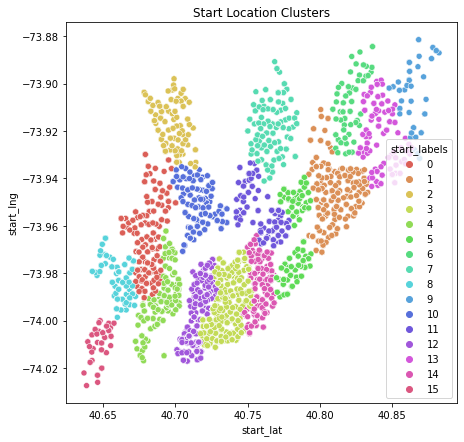

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(7,7))
sns.scatterplot(data=df, x="start_lat", y="start_lng", hue="start_labels",palette=sns.color_palette("hls",df.start_labels.nunique()))
plt.title('Start Location Clusters')
plt.show()

In [28]:
#for end location clusters

end_ac = ac.fit(dist_end)
end_labels = end_ac.labels_
df['end_labels']=end_labels
print(df['end_labels'].value_counts())

5     5516
12    2956
0     2169
6     1814
1     1017
2      703
10     655
3      580
14     436
13     331
9      261
7      206
4      189
11     104
8       44
Name: end_labels, dtype: int64


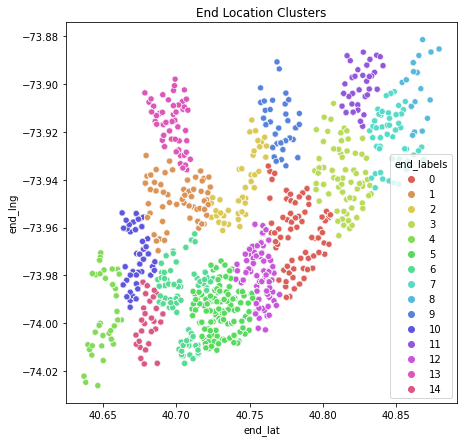

In [29]:

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(7,7))
sns.scatterplot(data=df, x="end_lat", y="end_lng", hue="end_labels",palette=sns.color_palette("hls",df.end_labels.nunique()))
plt.title('End Location Clusters')
plt.show()

In [30]:
#group the trips with the same cluster number for start and end
result = df.groupby(['start_labels', 'end_labels']).count().reset_index().iloc[:,0:3].rename(columns = {'rideable_type':'trips'})

In [31]:
result.sort_values("trips", ascending = False).head(40)

,start_labels,end_labels,trips
24,3,5,3074
82,12,5,1281
99,14,12,1158
26,3,12,1068
96,14,5,893
36,5,0,752
83,12,6,551
8,1,0,542
63,10,1,464
92,14,0,412


In [32]:
#with this I pick pairs of start and end clusters and construct new clusters based on this

df.loc[(df.start_labels == 3) & (df.end_labels ==5), 'cluster_labels'] = 0
df.loc[(df.start_labels == 14) & (df.end_labels ==12), 'cluster_labels'] = 1
df.loc[(df.start_labels == 5) & (df.end_labels ==0), 'cluster_labels'] = 2
df.loc[(df.start_labels == 12) & (df.end_labels ==6), 'cluster_labels'] = 3
df.loc[(df.start_labels == 10) & (df.end_labels ==1), 'cluster_labels'] = 4
df.loc[(df.start_labels == 1) & (df.end_labels ==3), 'cluster_labels'] = 5
df.loc[(df.start_labels == 0) & (df.end_labels ==10), 'cluster_labels'] = 6
df.loc[(df.start_labels == 4) & (df.end_labels ==14), 'cluster_labels'] = 7
df.loc[(df.start_labels == 2) & (df.end_labels ==13), 'cluster_labels'] = 8
df.loc[(df.start_labels == 7) & (df.end_labels ==9), 'cluster_labels'] = 9
df.loc[(df.start_labels == 11) & (df.end_labels ==2), 'cluster_labels'] = 10
df.loc[(df.start_labels == 13) & (df.end_labels ==7), 'cluster_labels'] = 11

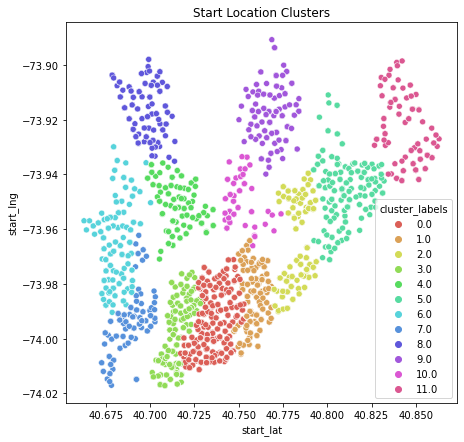

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(7,7))
sns.scatterplot(data=df, x="start_lat", y="start_lng", hue="cluster_labels",palette=sns.color_palette("hls",df.cluster_labels.nunique()))
plt.title('Start Location Clusters')
plt.show()

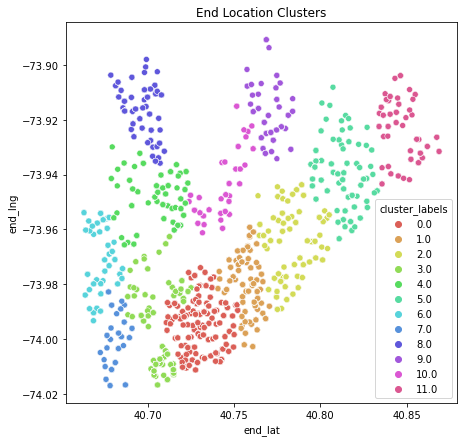

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(7,7))
sns.scatterplot(data=df, x="end_lat", y="end_lng", hue="cluster_labels",palette=sns.color_palette("hls",df.cluster_labels.nunique()))
plt.title('End Location Clusters')
plt.show()

In [35]:
# % of data being used
df.loc[df.cluster_labels.isna()==False,].shape[0]*100/df.shape[0]

45.768800424003295

In [36]:
#repeat process with data points left unclustered

df2 = df.loc[df.cluster_labels.isna()==True,]

# calculate distances between every point in the data set
#start locations

lat = np.radians(df2.start_lat)
lng = np.radians(df2.start_lng)
    
dist_start = sklearn_haversine(lat, lng)


#end locations

lat = np.radians(df2.end_lat)
lng = np.radians(df2.end_lng)
    
dist_end = sklearn_haversine(lat, lng)



#for start location clusters

start_ac = ac.fit(dist_start)
start_labels = start_ac.labels_
df2['start_labels']=start_labels

#for end location clusters

end_ac = ac.fit(dist_end)
end_labels = end_ac.labels_
df2['end_labels']=end_labels

#group the trips with the same cluster number for start and end
result = df2.groupby(['start_labels', 'end_labels']).count().reset_index().iloc[:,0:3].rename(columns = {'rideable_type':'trips'})

In [37]:
result.sort_values("trips", ascending = False).head(20)

,start_labels,end_labels,trips
18,2,12,1086
13,2,1,851
79,12,1,818
26,4,0,668
20,3,0,499
65,10,1,443
27,4,1,425
38,6,5,404
31,4,12,367
57,9,5,223


In [38]:
#with this I pick pairs of start and end clusters and construct new clusters based on this

df2.loc[(df2.start_labels == 2) & (df2.end_labels ==12), 'cluster_labels'] = 12
df2.loc[(df2.start_labels == 12) & (df2.end_labels ==1), 'cluster_labels'] = 13
df2.loc[(df2.start_labels == 4) & (df2.end_labels ==0), 'cluster_labels'] = 14
df2.loc[(df2.start_labels == 6) & (df2.end_labels ==5), 'cluster_labels'] = 15
df2.loc[(df2.start_labels == 9) & (df2.end_labels ==9), 'cluster_labels'] = 16
df2.loc[(df2.start_labels == 8) & (df2.end_labels ==8), 'cluster_labels'] = 17
df2.loc[(df2.start_labels == 10) & (df2.end_labels ==10), 'cluster_labels'] = 18

In [39]:
#final clusters will be those from df and df2 with a cluster label

data = df.loc[df.cluster_labels.isna()==False,].append(df2.loc[df2.cluster_labels.isna()==False,])

In [40]:
# % of data being used
data.shape[0]*100/df.shape[0]

66.40951651846181

In [41]:
# calculate max distance within each cluster for start and end locations to check results

#start locations
start_max_dist = []
print("Start Locations")
for i in data.cluster_labels.dropna().unique():

    aux = data.loc[data.cluster_labels==i,].reset_index()
    lat = np.radians(aux.start_lat)
    lng = np.radians(aux.start_lng)
    
    result = sklearn_haversine(lat, lng)
    max_dist = result.max()
    
    start_max_dist.append(np.rad2deg(max_dist))
    print("Cluster: "+str(i)+" max_dist = "+str(round(np.rad2deg(max_dist),3)))
    
#end locations
end_max_dist = []
print("End Locations")
for i in data.cluster_labels.dropna().unique():
    
    aux = data.loc[data.cluster_labels==i,].reset_index()
    lat = np.radians(aux.end_lat)
    lng = np.radians(aux.end_lng)
    
    result = sklearn_haversine(lat, lng)
    max_dist = result.max()
    
    end_max_dist.append(np.rad2deg(max_dist))
    print("Cluster: "+str(i)+" max_dist = "+str(round(np.rad2deg(max_dist),3)))
    
    
if np.array(start_max_dist).max() > 0.05:
    print("Max distance is exceeded by: " +  str(np.array(start_max_dist).max()-0.05))
else: 
    print("Max distance checks out by: " +  str(0.05-np.array(start_max_dist).max()))
if np.array(end_max_dist).max() > 0.05:
    print("Max distance is exceeded by :" + str(np.array(end_max_dist).max()-0.05))
else: 
    print("Max distance checks out by: " +  str(0.05-np.array(end_max_dist).max()))

Start Locations
Cluster: 1.0 max_dist = 0.032
Cluster: 10.0 max_dist = 0.033
Cluster: 3.0 max_dist = 0.036
Cluster: 4.0 max_dist = 0.039
Cluster: 8.0 max_dist = 0.043
Cluster: 0.0 max_dist = 0.04
Cluster: 2.0 max_dist = 0.042
Cluster: 6.0 max_dist = 0.046
Cluster: 5.0 max_dist = 0.046
Cluster: 9.0 max_dist = 0.037
Cluster: 11.0 max_dist = 0.037
Cluster: 7.0 max_dist = 0.044
Cluster: 12.0 max_dist = 0.035
Cluster: 15.0 max_dist = 0.036
Cluster: 13.0 max_dist = 0.029
Cluster: 14.0 max_dist = 0.043
Cluster: 17.0 max_dist = 0.03
Cluster: 18.0 max_dist = 0.034
Cluster: 16.0 max_dist = 0.038
End Locations
Cluster: 1.0 max_dist = 0.033
Cluster: 10.0 max_dist = 0.042
Cluster: 3.0 max_dist = 0.042
Cluster: 4.0 max_dist = 0.045
Cluster: 8.0 max_dist = 0.038
Cluster: 0.0 max_dist = 0.042
Cluster: 2.0 max_dist = 0.043
Cluster: 6.0 max_dist = 0.03
Cluster: 5.0 max_dist = 0.042
Cluster: 9.0 max_dist = 0.034
Cluster: 11.0 max_dist = 0.036
Cluster: 7.0 max_dist = 0.028
Cluster: 12.0 max_dist = 0.033
C

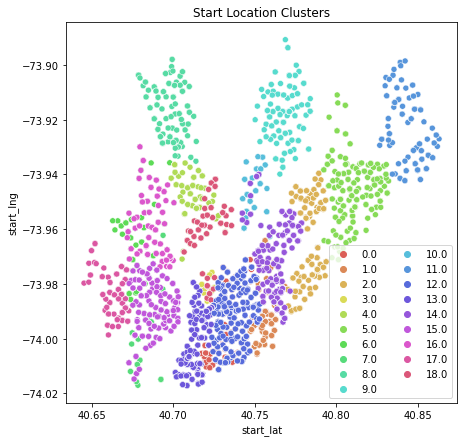

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(7,7))
sns.scatterplot(data=data, x="start_lat", y="start_lng", hue="cluster_labels",palette=sns.color_palette("hls",data.cluster_labels.nunique()))
plt.title('Start Location Clusters')
plt.legend(ncol= 2)
plt.show()

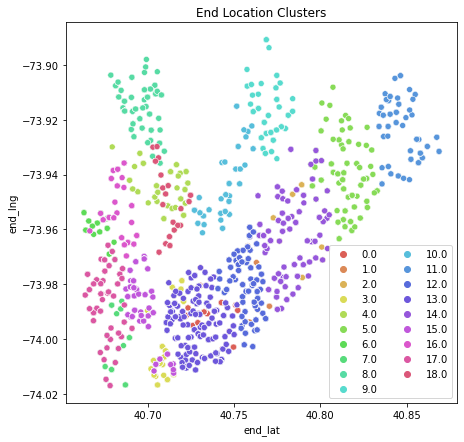

In [43]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(7,7))
sns.scatterplot(data=data, x="end_lat", y="end_lng", hue="cluster_labels",palette=sns.color_palette("hls",data.cluster_labels.nunique()))
plt.title('End Location Clusters')
plt.legend(ncol= 2)
plt.show()

##### (5) Evaluate your clustering with the help of clustering performance measures.

In [44]:
X = np.array(data[['start_lat', 'start_lng','end_lat','end_lng']])
labels = data.cluster_labels
sil_score = silhouette_score(X, labels)
print(round(sil_score,3))

0.186


##### (6) Briefly discuss the trip statistics for major trip groups/ clusters.

In [45]:
data[['time_seconds', 'distance_m', 'speed_m/s', 'cluster_labels']].groupby('cluster_labels').mean()

,time_seconds,distance_m,speed_m/s
cluster_labels,,,
0.0,563.347755,1281.225221,2.529353
1.0,509.811744,1148.485864,2.545978
2.0,646.159574,1401.933853,2.505454
3.0,640.068966,1279.179613,2.327145
4.0,612.797414,1383.202145,2.551992
5.0,532.970874,1198.066753,2.599126
6.0,561.137500,1379.735887,2.638906
7.0,642.861925,1253.553676,2.482959
8.0,458.420354,1155.564355,2.745181


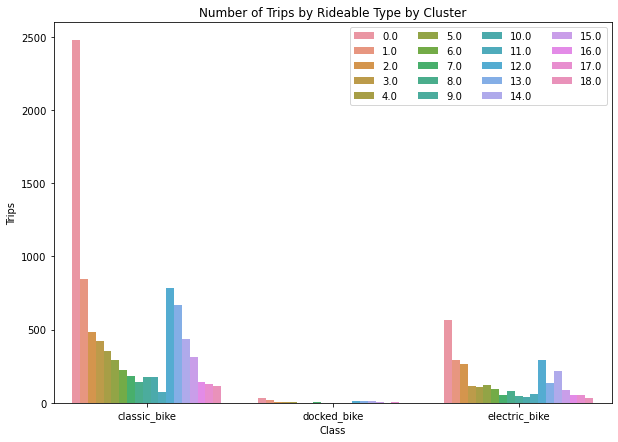

In [46]:
res = data[['rideable_type', 'cluster_labels']].groupby(['cluster_labels', 'rideable_type']).size().reset_index()
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,7))
sns.barplot(data=res, x="rideable_type", y=0, hue='cluster_labels')
plt.title('Number of Trips by Rideable Type by Cluster')
plt.xlabel('Class')
plt.ylabel('Trips')
plt.legend(loc='upper right',ncol=4)

plt.show()

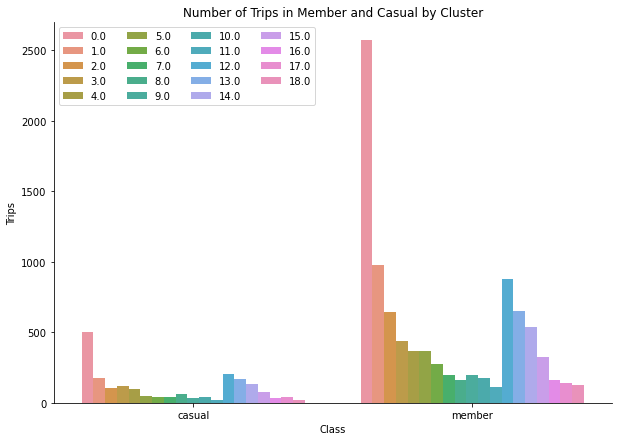

In [47]:
res = data[['member_casual', 'cluster_labels']].groupby(['cluster_labels', 'member_casual']).size().reset_index()
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,7))
sns.barplot(data=res, x="member_casual", y=0, hue='cluster_labels')
plt.title('Number of Trips in Member and Casual by Cluster')
plt.xlabel('Class')
plt.ylabel('Trips')
plt.legend(loc='upper left',ncol=4)
sns.despine()
plt.show()

##### (7) Finally, plot a network or graph visualization where nodes represent the origin and destination centers and the thickness of edges between nodes represent the number of trips assigned to that trip group.

In [48]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

In [49]:
#start
num_clusters= len(set(data.cluster_labels))
coords = np.array(data[['start_lat', 'start_lng']])
clusters = pd.Series([coords[data.cluster_labels == n] for n in range(num_clusters)])
centermost_points_start = clusters.map(get_centermost_point)

In [50]:
#end
num_clusters= len(set(data.cluster_labels))
coords = np.array(data[['end_lat', 'end_lng']])
clusters = pd.Series([coords[data.cluster_labels == n] for n in range(num_clusters)])
centermost_points_end = clusters.map(get_centermost_point)

In [51]:
pos = {}
count = 0
for i in range(0,num_clusters):
    pos[str(count)+'_s']= centermost_points_start[i]
    pos[str(count)+'_e']= centermost_points_end[i]
    count+=1

In [52]:
pos_start = {}
count = 0
for i in range(0,num_clusters):
    pos_start[str(count)+'_s']= centermost_points_start[i]
    count+=1

pos_end = {}
count = 0
for i in range(0,num_clusters):
    pos_end[str(count)+'_e']= centermost_points_end[i]
    count+=1

In [53]:
weights = {}
for i in range(0,len(pos_start)):
    key = (list(pos_start.keys())[i], list(pos_end.keys())[i])
    weights[key] = data['cluster_labels'].value_counts()[i]

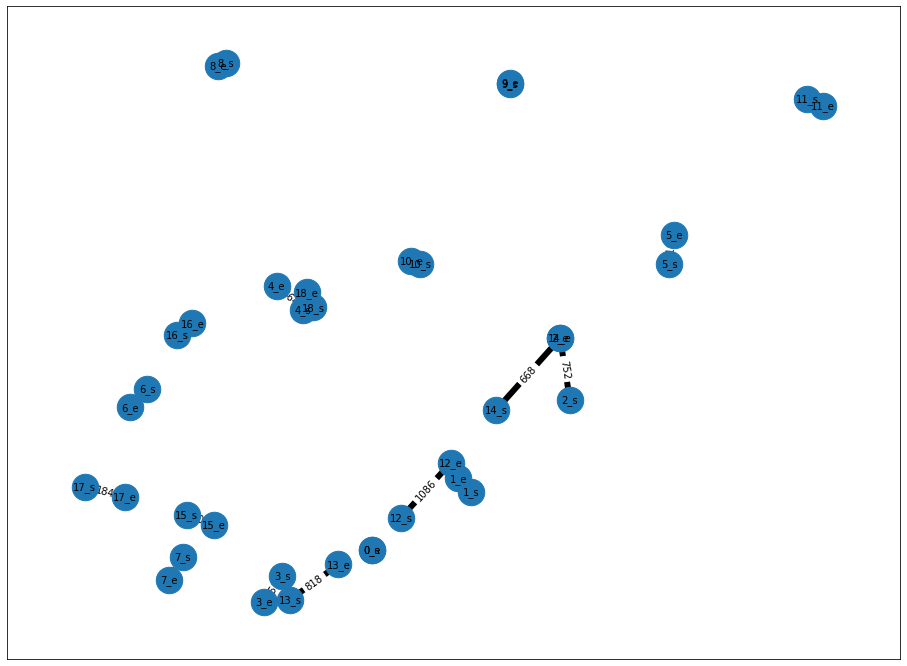

In [54]:
plt.figure(figsize=(16,12))
G = nx.Graph()
# each edge is a tuple of the form (node1, node2, {'weight': weight})
edges = [(k[0], k[1], {'weight': v}) for k, v in weights.items()]
G.add_edges_from(edges)

#pos = nx.spring_layout(G) # positions for all nodes

# nodes
nx.draw_networkx_nodes(G,pos,node_size=700)

# labels
nx.draw_networkx_labels(G,pos,font_size=10,font_family='sans-serif')

# edges
nx.draw_networkx_edges(G,pos,edgelist=edges, width=6)

# weights
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

plt.show()

### Problem 4

In [55]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import numpy as np
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import shapiro
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from pmdarima import auto_arima

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [56]:
#read data
df = pd.read_csv("apple_mobility_trends.csv")

In [57]:
df.head()

,Unnamed: 0,driving,walking
0,2020-01-13,100.00,100.00
1,2020-01-14,103.02,106.97
2,2020-01-15,104.46,110.12
3,2020-01-16,106.00,107.98
4,2020-01-17,115.29,129.50


In [58]:
#change column name
df.rename(columns={"Unnamed: 0":"date"}, inplace=True)

In [59]:
df.dtypes

date        object
driving    float64
walking    float64
dtype: object

In [60]:
#check for missing values
df.isna().sum()

date       0
driving    0
walking    0
dtype: int64

##### 1) Statistical summary of the original data

In [61]:
df.describe()

,driving,walking
count,174.000000,174.000000
mean,88.446724,84.803678
std,31.571044,32.714109
min,21.130000,17.550000
25%,59.777500,54.282500
50%,97.980000,85.480000
75%,111.035000,107.112500
max,164.700000,169.220000


##### 2) Data visualization and discussing the patterns 

In [62]:
#set date column as datetime type
df['date'] = pd.to_datetime(df['date'])

In [63]:
df.dtypes

date       datetime64[ns]
driving           float64
walking           float64
dtype: object

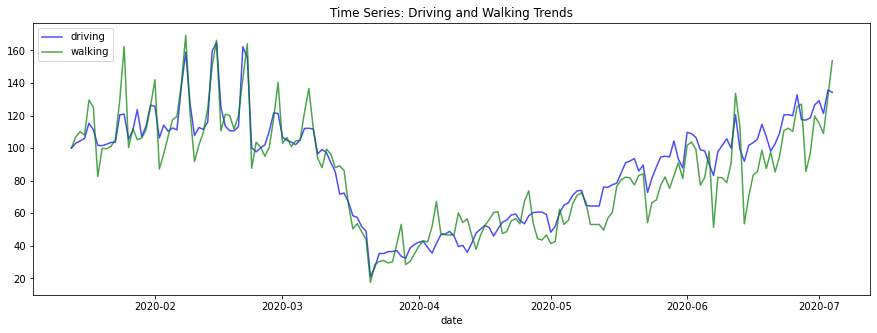

In [64]:
#plot walking and driving
plt.figure(figsize=(15,5))
plt.plot(df['date'], df['driving'], color= 'b', label='driving', alpha = 0.70)
plt.plot(df['date'], df['walking'], color= 'g', label='walking', alpha = 0.70)
plt.legend()
plt.xlabel('date')
plt.title('Time Series: Driving and Walking Trends')
plt.show()

Trend: at the beginning the trend seems to remain constant. However, from approximately March 2020 until the end of the month, there seems to be a decrease in the measurements for walking and driving. The trend appears to be reversed towards the end of March and the measurements for both driving and walking increase until July 2020. 

Seasonality: there seems to be some seasonality at certain points for the time-series. For example, between February and March there appear to be seasonality components in the time series for both walking and driving.

Variance: there are certain periods where the variance appears to be greater than in other. Therefore, the variance appears to be time-dependent.


##### 3) Data split into training and test data

In [65]:
test_size = 14
xt_driving = np.array(df.driving)[:-test_size]
xt_walking = np.array(df.walking)[:-test_size]

##### 4) Decomposition of both the time series

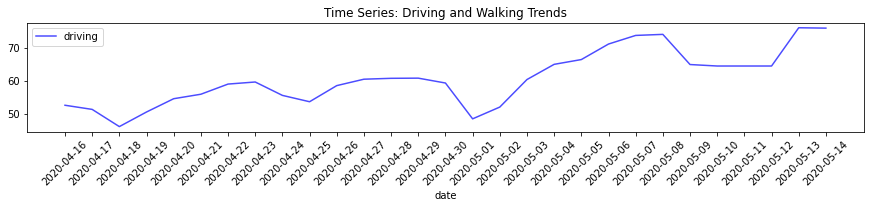

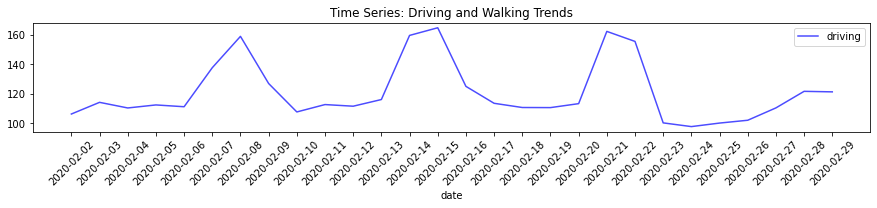

In [66]:
#zoom in to determine period
aux =df.loc[(df['date']>'2020-04-15') & (df['date']<'2020-05-15')]
plt.figure(figsize=(15,2))
plt.plot(aux['date'], aux['driving'], color= 'b', label='driving', alpha = 0.70)
plt.legend()
plt.xticks(aux['date'],rotation=45)
plt.xlabel('date')
plt.title('Time Series: Driving and Walking Trends')
plt.show()

aux =df.loc[(df['date']>'2020-02-01') & (df['date']<'2020-03-01')]
plt.figure(figsize=(15,2))
plt.plot(aux['date'], aux['driving'], color= 'b', label='driving', alpha = 0.70)
plt.legend()
plt.xticks(aux['date'],rotation=45)
plt.xlabel('date')
plt.title('Time Series: Driving and Walking Trends')
plt.show()

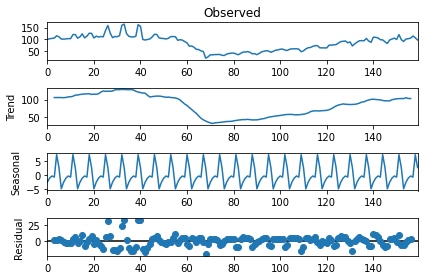

In [67]:
res_driving =seasonal_decompose(xt_driving, period=7)
res_driving.plot()
plt.show()

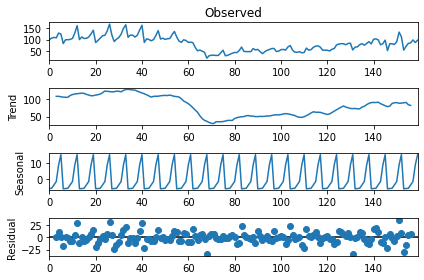

In [68]:
res_walking =seasonal_decompose(xt_walking, period=7)
res_walking.plot()
plt.show()

##### 5) Testing the time-series for stationarity using statistical tools.

Augmented Dickey Fuller (ADF) test and Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test are both tests to check for stationarity.

ADF

To determine the presence of unit root in the series, and hence helps in
understand if the series is stationary or not.

Hypothesis of this test are:

• Null Hypothesis: The series has a unit root (is not stationary).

• Alternate Hypothesis: The series has no unit root.

If the null hypothesis in failed to be rejected, this test may provide evidence
that the series is non-stationary.

KPSS

KPSS is another test for checking the stationarity of a time series.

Null and alternate hypothesis for the KPSS test are opposite that of the
ADF test.

• Null Hypothesis: The process is trend stationary.

• Alternate Hypothesis: The series has a unit root (series is not
stationary).

In [69]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
        


def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [70]:
#For driving
print(adf_test(xt_driving))
print(kpss_test(xt_driving))

Results of Dickey-Fuller Test:
Test Statistic                  -1.455861
p-value                          0.555222
#Lags Used                       8.000000
Number of Observations Used    151.000000
Critical Value (1%)             -3.474416
Critical Value (5%)             -2.880878
Critical Value (10%)            -2.577081
dtype: float64
None
Results of KPSS Test:
Test Statistic           0.585987
p-value                  0.023910
Lags Used                8.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
None


At a significance level of 5%, we can't reject the null hypotheses for the Dickey-Fuller test, meaning the series would not be stationary. For the KPSS test, the null hypothesis is rejected at the 5% significance level, which indicates that the series is non-stationary. Therefore, because both tests conclude that the series is not stationary, the series is not stationary.


In [71]:
#we need to make the data stationary by applying differences
first_diff = xt_driving[1:] - xt_driving[:-1]
presumed_seasonality = 7
seasonal_difference = xt_driving[presumed_seasonality:] - xt_driving[:-presumed_seasonality]
seasonal_first_difference = seasonal_difference[1:] - seasonal_difference[:-1]

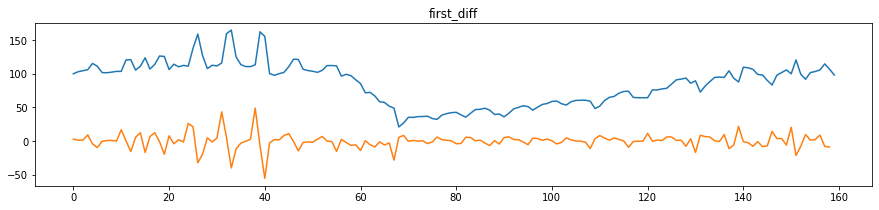

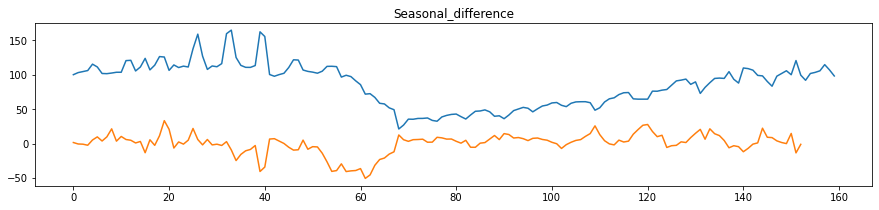

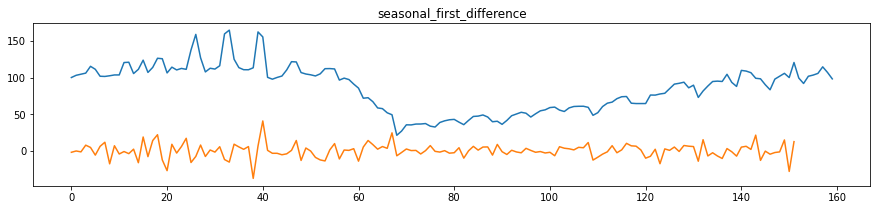

In [72]:
plt.figure(figsize=(15,3))
plt.plot(xt_driving)
plt.plot(first_diff)
plt.title('first_diff')
plt.show()


plt.figure(figsize=(15,3))
plt.plot(xt_driving)
plt.plot(seasonal_difference)
plt.title('Seasonal_difference')
plt.show()

plt.figure(figsize=(15,3))
plt.plot(xt_driving)
plt.plot(seasonal_first_difference)
plt.title('seasonal_first_difference')
plt.show()



In [73]:
#test if its stationary
print(adf_test( seasonal_first_difference))
print(kpss_test(seasonal_first_difference))

Results of Dickey-Fuller Test:
Test Statistic                  -5.483827
p-value                          0.000002
#Lags Used                       8.000000
Number of Observations Used    143.000000
Critical Value (1%)             -3.476927
Critical Value (5%)             -2.881973
Critical Value (10%)            -2.577665
dtype: float64
None
Results of KPSS Test:
Test Statistic           0.039484
p-value                  0.100000
Lags Used                8.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
None


At a 5% significance level, we can reject the ADF null hypotheses (time series not stationary), so we can say the time series is stationary. For the KPSS test, we can't reject the null hypotheses (time series stationary), therefore we can say the time series is stationary. 

##### 6) ACF and PACF analysis

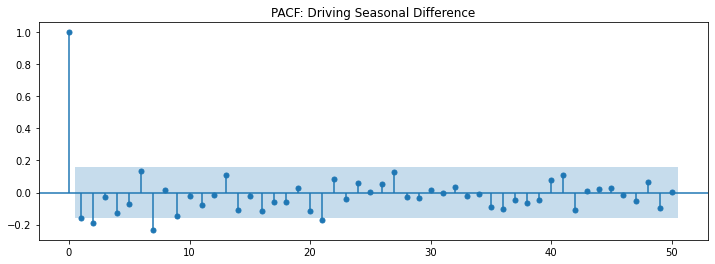

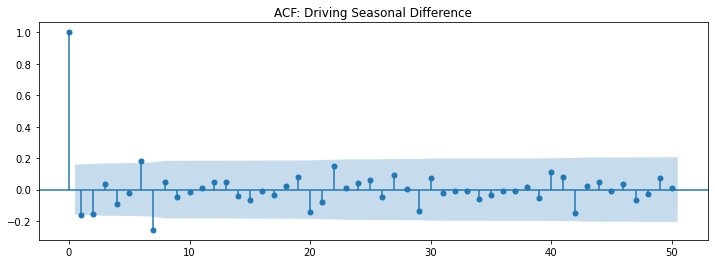

In [74]:
fig = plot_pacf(seasonal_first_difference, title='PACF: Driving Seasonal Difference', lags=50, method="ywm");
fig.set_size_inches((12, 4))

fig = plot_acf(seasonal_first_difference, title='ACF: Driving Seasonal Difference', lags=50);
fig.set_size_inches((12, 4))

ACF: spike at lag 7 but no other significant spikes;
PACF: exponential decay in the seasonal


For SARIMA model, this indicates a potential parameter starting point of SARIMA(2,1,0)x(0,1,1,7)


##### (7) Model specification, parameter estimation, and significance test.

In [75]:
model = ARIMA(xt_driving, order=(2,1,1), seasonal_order=(0,1,1,7))

res = model.fit()

print(res.summary())

                                    SARIMAX Results                                    
Dep. Variable:                               y   No. Observations:                  160
Model:             ARIMA(2, 1, 1)x(0, 1, 1, 7)   Log Likelihood                -547.276
Date:                         Wed, 17 Aug 2022   AIC                           1104.553
Time:                                 13:29:49   BIC                           1119.672
Sample:                                      0   HQIC                          1110.695
                                         - 160                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4501      0.221      2.037      0.042       0.017       0.883
ar.L2         -0.1856      0.090     -2.065      0.039     

##### (8) Criteria for model selection 

In [76]:

# Fit auto_arima function 
stepwise_fit = auto_arima(xt_driving, start_p = 1, start_q = 1,
max_p = 4, max_q = 4, m = 7,
start_P = 0, seasonal = True,
d = 1, D = 1, trace = True,
error_action ='ignore', # we don't want to know if an order does not work
suppress_warnings = True, # we don't want convergence warnings
stepwise = True) # set to stepwise

# To print the summary
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=1105.380, Time=0.07 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=1124.032, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=1115.082, Time=0.03 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=1111.072, Time=0.03 sec
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=1114.005, Time=0.04 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=inf, Time=0.14 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=1103.934, Time=0.12 sec
 ARIMA(1,1,1)(1,1,2)[7]             : AIC=inf, Time=0.36 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=1109.828, Time=0.07 sec
 ARIMA(1,1,0)(0,1,2)[7]             : AIC=1111.050, Time=0.07 sec
 ARIMA(2,1,1)(0,1,2)[7]             : AIC=1102.832, Time=0.15 sec
 ARIMA(2,1,1)(0,1,1)[7]             : AIC=1104.553, Time=0.10 sec
 ARIMA(2,1,1)(1,1,2)[7]             : AIC=inf, Time=0.45 sec
 ARIMA(2,1,1)(1,1,1)[7]             : AIC=1098.179, Time=0.17 sec
 ARIMA(2,1,1)(1,1,0)[7]             : AIC=1109.1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  160
Model:             SARIMAX(0, 1, 2)x(1, 1, [1], 7)   Log Likelihood                -542.876
Date:                             Wed, 17 Aug 2022   AIC                           1095.753
Time:                                     13:29:58   BIC                           1110.872
Sample:                                          0   HQIC                          1101.895
                                             - 160                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1647      0.083     -1.992      0.046      -0.327      -0.003
ma.L2         -0.2794      0.071     -3.944      0.000      -0.418      -0.141
ar.S.L7        0.5159      0.089      5.808      0.000       0.342       0.690
ma.S.L7       -0.9043      0.094     -9.589      0.000      -1.089      -0.719
sigma2        71.4639      7.709      9.270      0.000      56.354      86.574
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 6.94
Prob(Q):                              0.89   Prob(JB):                         0.03
Heteroskedasticity (H):               0.61   Skew:                            -0.30
Prob(H) (two-sided):                  0.08   Kurtosis:                         3.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

##### (9) Model diagnosis

If the model is correctly specified and the parameter estimates are
reasonably close to the true values, then the residuals should have nearly
the properties of white noise.

They should behave roughly like independent, identically distributed normal
variables with zero means and common standard deviations. 

• The residuals are uncorrelated. If there are correlations between
residuals, then there is information left in the residuals which should be
used in computing forecasts.

• The residuals have zero mean. If the residuals have a mean other than
zero, then the forecasts are biased.

• The residuals have constant variance.

• The residuals are normally distributed.

In [77]:
model = ARIMA(xt_driving, order=(0,1,2), seasonal_order=(1,1,1,7))
res = model.fit()


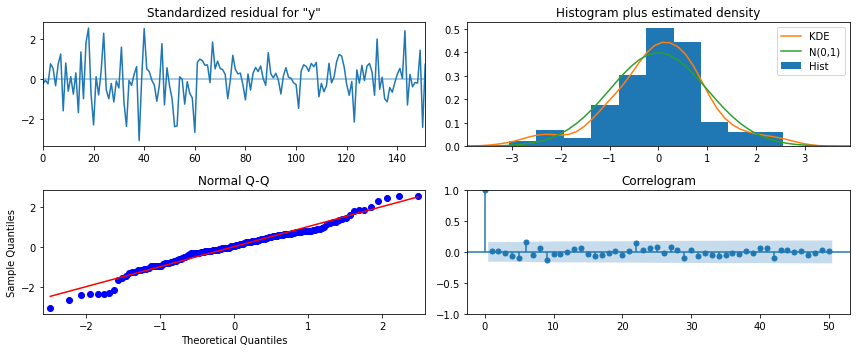

In [78]:
res.plot_diagnostics(lags=50, figsize=(12,5))
plt.tight_layout()

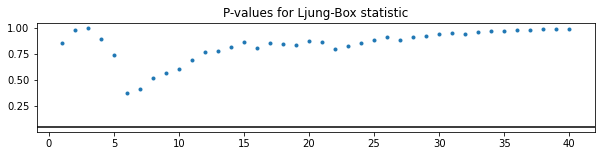

In [79]:

L_box = sm.stats.acorr_ljungbox(res.resid[7:],return_df=True)

plt.figure(figsize=(10,2))
plt.axhline(y=0.05, color='black')
plt.plot(L_box['lb_pvalue'],marker='.', linestyle='none')
plt.title('P-values for Ljung-Box statistic')
plt.show()

##### (10) Error metrics and forecasting performance on test data 

Error Metrics: I use one scale-dependent, one percentage-error metric and one scale-free.

Scale-dependent

• Mean Absolute Error (MAE)

Percentage-error metrics

• Mean Absolute Percentage Error (MAPE)

Scale-free

• R-Squared

In [80]:
def metrics(y_true, y_pred):
    mae = round(mean_absolute_error(y_true, y_pred),2)
    print("MAE:" + str(mae))
    mape= round(mean_absolute_percentage_error(y_true, y_pred),2)
    print("MAPE:"+ str(mape))
    r2= round(r2_score(y_true, y_pred),2)
    print("R2:"+ str(r2))

In [81]:
print("Train Set")
metrics(xt_driving, res.get_prediction().summary_frame()['mean'])

Train Set
MAE:7.24
MAPE:0.1
R2:0.84


In [82]:
forecasts = res.get_forecast(steps=test_size)
y_test= np.array(df.driving)[-test_size:]
print("Test Set")
metrics(y_test, forecasts.summary_frame()['mean'])

Test Set
MAE:16.55
MAPE:0.13
R2:-3.02


##### (11) Plot original time series, forecasted values, and confidence intervals.

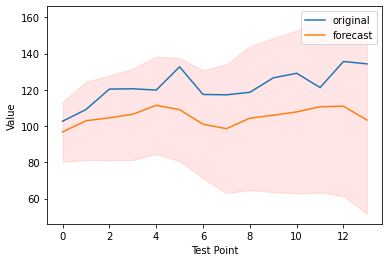

In [83]:
forecasts = res.get_forecast(steps=test_size)
plt.plot(np.array(df.driving)[-test_size:], label='original')
plt.plot(forecasts.summary_frame()['mean'], label='forecast')
plt.fill_between(range(test_size), 
                 forecasts.summary_frame()['mean_ci_lower'], 
                 forecasts.summary_frame()['mean_ci_upper'], 
                 alpha=0.1, color='r')
plt.xlabel('Test Point')
plt.ylabel('Value')
plt.legend()
plt.show()

##### (12) Now repeat steps (7) and (10) by using a model which predicts one step at a time, and each step uses the new data to update the model. Compare the results with the previous model. 

Test Set
MAE:5.0
MAPE:0.04
R2:0.45


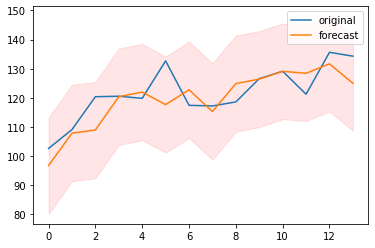

In [84]:
#empty list to save one-step forecasts
y_pred = []
ci_lower=[]
ci_upper=[]
#define and fit model
test_size =14

#one-step forecast
for i in range(0,test_size):
    
    model = ARIMA(np.array(df.driving)[:-(14-i)], order=(0,1,2), seasonal_order=(1,1,1,7))
    res = model.fit()
    y_pred.append(res.get_forecast(steps=1).summary_frame()['mean'])
    ci_lower.append(res.get_forecast(steps=1).summary_frame()['mean_ci_lower'])
    ci_upper.append(res.get_forecast(steps=1).summary_frame()['mean_ci_upper'])

#Metrics
y_test= np.array(df.driving)[-test_size:]
print("Test Set")
metrics(y_test, np.array(y_pred).ravel())
    
#plot
plt.plot(np.array(df.driving)[-test_size:], label='original')
plt.plot(np.array(y_pred).ravel(), label='forecast')
plt.fill_between(range(test_size), 
                 np.array(ci_lower).ravel(), 
                 np.array(ci_upper).ravel(), 
                 alpha=0.1, color='r')
plt.legend()
plt.show()